# Decision Trees

# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Install Scikit-learn if not already installed
!pip install -U scikit-learn

# Scikit-learn components
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Matplotlib color utilities
from matplotlib.colors import ListedColormap


#Part 1: Decision Trees

## Define the Path to the Dataset

We set up the base path to the dataset directory. Ensuring the dataset is correctly imported. The dataset must be imported after running the Preprocessing.ipynb notebook

In [ ]:

# Load the dataset
os.chdir('/Users/mary/Downloads/F20DL_UG_Group_2/') # this will be the path to your local directory where the preprocessed.csv is saved
file_path = 'preprocessed.csv' 
df = pd.read_csv("file_path")


**Step 1: Categorizing Coffee Quality Based on Total Cup Points & Selecting Relevant Features**

In [55]:
# Check if 'Total Cup Points' exists
if 'Total Cup Points' in data.columns:
    # Normalize 'Total Cup Points'
    data['Total Cup Points/60'] = data['Total Cup Points'] / 60

    # Define thresholds for categorization
    low_threshold = data['Total Cup Points/60'].quantile(0.33)
    high_threshold = data['Total Cup Points/60'].quantile(0.66)

    # Categorize based on thresholds
    def categorize_quality(score):
        if score <= low_threshold:
            return 'Low Quality'
        elif score <= high_threshold:
            return 'Moderate Quality'
        else:
            return 'High Quality'

    # Apply categorization
    data['Quality Category'] = data['Total Cup Points/60'].apply(categorize_quality)

    print(data['Quality Category'].value_counts())  # Check the created column
else:
    print("Column 'Total Cup Points' not found in the dataframe.")


# Define class_mapping for label encoding
class_mapping = {'Low Quality': 0, 'Moderate Quality': 1, 'High Quality': 2}

# Encode the target variable using class_mapping
y = np.array([class_mapping[label] for label in data['Quality Category']], dtype=np.int64)



Quality Category
Moderate Quality    71
High Quality        68
Low Quality         68
Name: count, dtype: int64


**Building a Decision Tree Classifier on the  Coffee Quality Data and Plotting the tree**

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.82      0.90        17
           2       0.75      1.00      0.86         9

    accuracy                           0.93        42
   macro avg       0.92      0.94      0.92        42
weighted avg       0.95      0.93      0.93        42

Accuracy Score: 0.9285714285714286


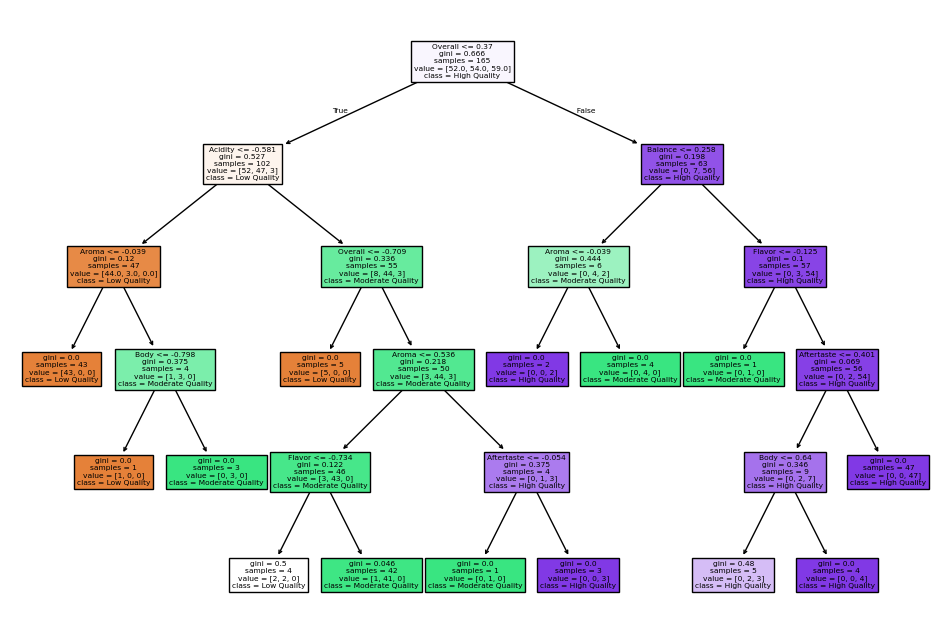

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Step 1: Select the original feature set and target variable
X = data[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']].values
y = np.array([class_mapping[label] for label in data['Quality Category']], dtype=np.int64)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the decision tree on the full feature set
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)  # Adjust max_depth as needed
tree_clf.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = tree_clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Step 5: Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall'], 
          class_names=['Low Quality', 'Moderate Quality', 'High Quality'], 
          filled=True)
plt.show()


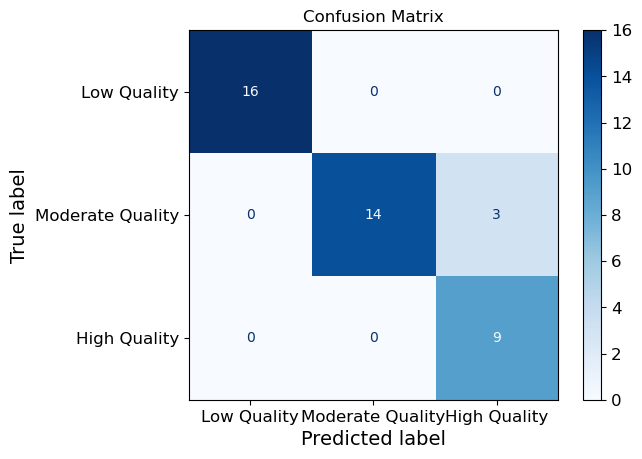

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Quality', 'Moderate Quality', 'High Quality'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## Predicting classes and class probabilities

In [61]:
# Predict the probabilities for a new sample
new_sample = [[-2, 0.9, 1.2, 0.5, -0.7, 2.3, 1.0]]  # Example 7 features
predicted_probabilities = tree_clf.predict_proba(new_sample)
print(f"Predicted Probabilities: {predicted_probabilities}")

predicted_class = tree_clf.predict(new_sample)
print(f"Predicted Class: {predicted_class}")


Predicted Probabilities: [[0. 0. 1.]]
Predicted Class: [2]


## Regularization Hyperparameters

**To avoid overfitting the training data, we need to restrict the Decision Tree’s freedom during training. This is called regularization.

## Experimenting with min_samples_leaf-minimum number of samples required in a leaf node

min_samples_leaf: 1, Cross-Validated Accuracy: 0.8788
min_samples_leaf: 2, Cross-Validated Accuracy: 0.8727
min_samples_leaf: 3, Cross-Validated Accuracy: 0.8667
min_samples_leaf: 4, Cross-Validated Accuracy: 0.8485
min_samples_leaf: 5, Cross-Validated Accuracy: 0.8485
min_samples_leaf: 6, Cross-Validated Accuracy: 0.8121
min_samples_leaf: 7, Cross-Validated Accuracy: 0.8303
min_samples_leaf: 8, Cross-Validated Accuracy: 0.8364
min_samples_leaf: 9, Cross-Validated Accuracy: 0.8242
min_samples_leaf: 10, Cross-Validated Accuracy: 0.8242
min_samples_leaf: 15, Cross-Validated Accuracy: 0.8364
min_samples_leaf: 20, Cross-Validated Accuracy: 0.8364


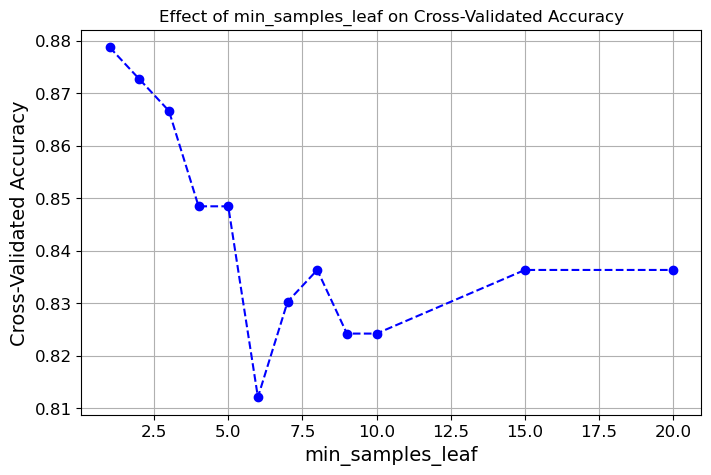

In [65]:
# Define a range of values for min_samples_leaf
min_samples_leaf_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,15,20]

# Initialize an empty list to store cross-validated accuracy scores
cross_val_scores_leaf = []

# Perform cross-validation for each value of min_samples_leaf
for min_samples in min_samples_leaf_values:
    # Train the decision tree with the specified min_samples_leaf
    tree_clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=min_samples, random_state=42)
    # Perform 5-fold cross-validation
    scores = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_scores_leaf.append(scores.mean())
    print(f"min_samples_leaf: {min_samples}, Cross-Validated Accuracy: {scores.mean():.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_values, cross_val_scores_leaf, marker='o', linestyle='--', color='b')
plt.xlabel('min_samples_leaf')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of min_samples_leaf on Cross-Validated Accuracy')
plt.grid(True)
plt.show()


This parameter helps prevent overfitting by avoiding overly specific splits that capture noise rather than meaningful patterns. Smaller values, such as 1 or 2, allow the tree to grow deeper, making more granular splits, which may lead to overfitting as the tree becomes too complex. Larger values, on the other hand, restrict the tree's ability to split, resulting in a simpler model that risks underfitting by missing important patterns in the data. The plot demonstrates this behavior, with accuracy initially improving as the tree balances flexibility and generalization, peaking at an optimal value (3-5), where the tree captures meaningful patterns without overfitting. Beyond this point, accuracy drops as the tree becomes too simplistic with higher min_samples_leaf values, leading to underfitting. Finding the optimal value ensures a good balance between complexity and generalization, maximizing cross-validated accuracy.

## Experimenting with max_depth_values -maximum number of splits that the tree can grow to

max_depth: 1, Cross-Validated Accuracy: 0.6303
max_depth: 2, Cross-Validated Accuracy: 0.8545
max_depth: 3, Cross-Validated Accuracy: 0.8788
max_depth: 5, Cross-Validated Accuracy: 0.8788
max_depth: 7, Cross-Validated Accuracy: 0.8727
max_depth: 10, Cross-Validated Accuracy: 0.8667
max_depth: 15, Cross-Validated Accuracy: 0.8667
max_depth: None, Cross-Validated Accuracy: 0.8667

Best max_depth (from CV): 3
Precision: 0.9357
Recall: 0.9286
F1-Score: 0.9295


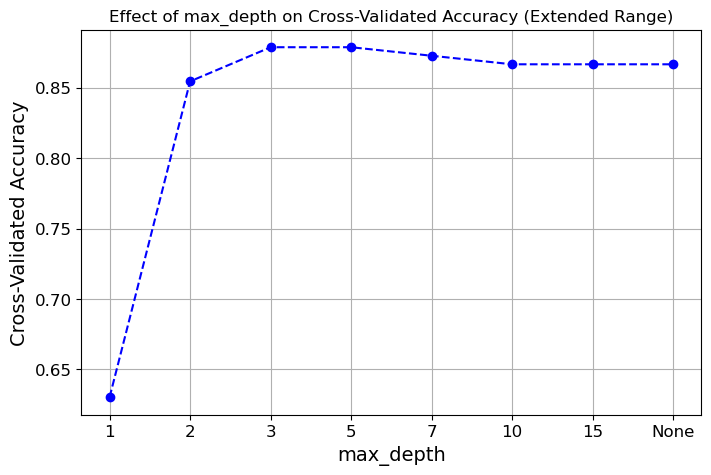

In [69]:
# Extended range of depths to test
max_depth_values = [1, 2, 3, 5, 7, 10, 15, None]  # Including a broader range of depths

cross_val_scores = []

# Perform cross-validation for each max_depth value
for depth in max_depth_values:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_scores.append(scores.mean())
    print(f"max_depth: {depth}, Cross-Validated Accuracy: {scores.mean():.4f}")

# Train the best model based on cross-validation results
best_depth = max_depth_values[cross_val_scores.index(max(cross_val_scores))]
best_tree_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_tree_clf.fit(X_train, y_train)
y_pred_best = best_tree_clf.predict(X_test)

# Compute additional metrics for the best model
precision = precision_score(y_test, y_pred_best, average='weighted')
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

# Display results
print(f"\nBest max_depth (from CV): {best_depth}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(
    [str(d) if d is not None else "None" for d in max_depth_values], 
    cross_val_scores, 
    marker='o', 
    linestyle='--', 
    color='b'
)
plt.xlabel('max_depth')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of max_depth on Cross-Validated Accuracy (Extended Range)')
plt.grid(True)
plt.show()


In the plot, when max_depth is set to a low value, such as 1, the tree is overly simplistic and underfits the data, resulting in low cross-validated accuracy. As the max_depth increases, the tree captures more patterns, and accuracy improves significantly, reaching an optimal value at around 3-5, where the model strikes a balance between underfitting and overfitting. Beyond this range, the accuracy plateaus or slightly fluctuates because additional depth adds minimal benefit and may even lead to overfitting. However, in this dataset, deeper trees (e.g., max_depth=10 or None) maintain stable accuracy, suggesting the data is not noisy or overly complex.

## Experimenting with max_leaf_nodes (maximum number of leaf nodes)

max_leaf_nodes: 2, Cross-Validated Accuracy: 0.6303
max_leaf_nodes: 5, Cross-Validated Accuracy: 0.8667
max_leaf_nodes: 10, Cross-Validated Accuracy: 0.8909
max_leaf_nodes: 20, Cross-Validated Accuracy: 0.8667
max_leaf_nodes: 50, Cross-Validated Accuracy: 0.8667
max_leaf_nodes: 100, Cross-Validated Accuracy: 0.8667
max_leaf_nodes: None, Cross-Validated Accuracy: 0.8667

Best max_leaf_nodes (from CV): 10
Precision: 0.9341
Recall: 0.9048
F1-Score: 0.9071


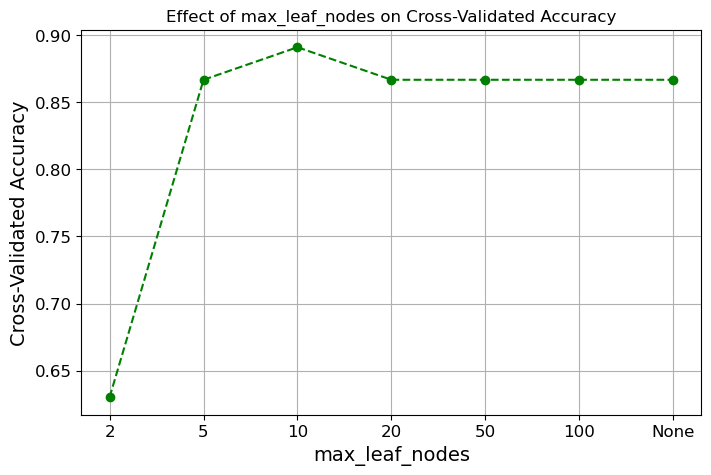

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define a range of values for max_leaf_nodes
max_leaf_nodes_values = [2, 5, 10, 20, 50, 100, None]  # Including None for unlimited leaf nodes
cross_val_scores_leaf_nodes = []

# Perform cross-validation for each max_leaf_nodes value
for max_leaf in max_leaf_nodes_values:
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=max_leaf, random_state=42)
    # 5-fold cross-validation
    scores = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_scores_leaf_nodes.append(scores.mean())
    print(f"max_leaf_nodes: {max_leaf}, Cross-Validated Accuracy: {scores.mean():.4f}")

# Train the best model based on cross-validation
best_max_leaf_nodes = max_leaf_nodes_values[cross_val_scores_leaf_nodes.index(max(cross_val_scores_leaf_nodes))]
best_tree_clf_leaf_nodes = DecisionTreeClassifier(max_leaf_nodes=best_max_leaf_nodes, random_state=42)
best_tree_clf_leaf_nodes.fit(X_train, y_train)
y_pred_best_leaf_nodes = best_tree_clf_leaf_nodes.predict(X_test)

# Calculate additional metrics
precision_leaf_nodes = precision_score(y_test, y_pred_best_leaf_nodes, average='weighted')
recall_leaf_nodes = recall_score(y_test, y_pred_best_leaf_nodes, average='weighted')
f1_leaf_nodes = f1_score(y_test, y_pred_best_leaf_nodes, average='weighted')

# Display results
print(f"\nBest max_leaf_nodes (from CV): {best_max_leaf_nodes}")
print(f"Precision: {precision_leaf_nodes:.4f}")
print(f"Recall: {recall_leaf_nodes:.4f}")
print(f"F1-Score: {f1_leaf_nodes:.4f}")

# Plot cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(
    [str(n) if n is not None else "None" for n in max_leaf_nodes_values], 
    cross_val_scores_leaf_nodes, 
    marker='o', 
    linestyle='--', 
    color='g'
)
plt.xlabel('max_leaf_nodes')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of max_leaf_nodes on Cross-Validated Accuracy')
plt.grid(True)
plt.show()


In the plot, a very low value for max_leaf_nodes (e.g., 2) restricts the tree excessively, causing underfitting and low cross-validated accuracy. As max_leaf_nodes increases, accuracy improves rapidly and stabilizes at around 5-10, where the model finds an optimal balance between underfitting and overfitting. Beyond this point, increasing the number of leaf nodes (e.g., 20, 50, or 100) does not significantly improve accuracy, as the tree already captures all meaningful patterns in the data. Allowing unlimited leaf nodes (None) similarly has no added benefit, indicating that the dataset's complexity does not require additional splits. The optimal range for max_leaf_nodes ensures that the model generalizes well while avoiding unnecessary complexity.

## Experimenting with max_features_values-maximum number of features to consider when determining the best split at each node.

max_features: 1, Cross-Validated Accuracy: 0.8303
max_features: 2, Cross-Validated Accuracy: 0.8909
max_features: 3, Cross-Validated Accuracy: 0.8667
max_features: 5, Cross-Validated Accuracy: 0.8364
max_features: None, Cross-Validated Accuracy: 0.8667

Best max_features (from CV): 2
Precision: 0.8659
Recall: 0.8571
F1-Score: 0.8526


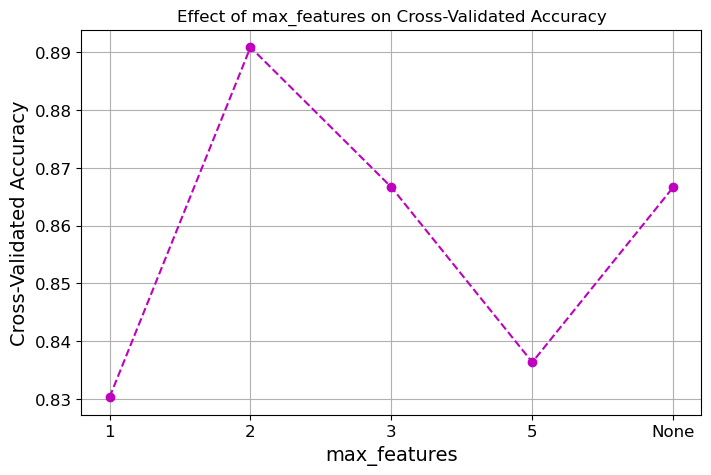

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define a range of values for max_features
max_features_values = [1, 2, 3, 5, None]  # Including None for all features
cross_val_scores_max_features = []

# Perform cross-validation for each max_features value
for max_features in max_features_values:
    tree_clf = DecisionTreeClassifier(max_features=max_features, random_state=42)
    # Perform 5-fold cross-validation
    scores = cross_val_score(tree_clf, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_scores_max_features.append(scores.mean())
    print(f"max_features: {max_features}, Cross-Validated Accuracy: {scores.mean():.4f}")

# Find the best max_features value
best_max_features = max_features_values[cross_val_scores_max_features.index(max(cross_val_scores_max_features))]

# Train the best model based on cross-validation
best_tree_clf_max_features = DecisionTreeClassifier(max_features=best_max_features, random_state=42)
best_tree_clf_max_features.fit(X_train, y_train)
y_pred_best_max_features = best_tree_clf_max_features.predict(X_test)

# Calculate additional metrics
precision_max_features = precision_score(y_test, y_pred_best_max_features, average='weighted')
recall_max_features = recall_score(y_test, y_pred_best_max_features, average='weighted')
f1_max_features = f1_score(y_test, y_pred_best_max_features, average='weighted')

# Display results
print(f"\nBest max_features (from CV): {best_max_features}")
print(f"Precision: {precision_max_features:.4f}")
print(f"Recall: {recall_max_features:.4f}")
print(f"F1-Score: {f1_max_features:.4f}")

# Plot cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(
    [str(n) if n is not None else "None" for n in max_features_values], 
    cross_val_scores_max_features, 
    marker='o', 
    linestyle='--', 
    color='m'
)
plt.xlabel('max_features')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Effect of max_features on Cross-Validated Accuracy')
plt.grid(True)
plt.show()


In the plot, a very low value for max_features (e.g., 1) limits the model's ability to utilize enough features for effective splits, leading to underfitting and lower cross-validated accuracy. As max_features increases, accuracy improves significantly, peaking at an optimal value of 2, where the tree strikes a balance between using enough features to capture meaningful patterns and avoiding overfitting. Beyond this point (e.g., 3, 5, or None), accuracy either stabilizes or slightly declines, as the tree becomes more complex without gaining significant improvements.

## Experimenting with varying the size of the training-testing data

Test Size: 0.1, Training Size: 0.9, Accuracy: 0.9524
Test Size: 0.2, Training Size: 0.8, Accuracy: 0.9286
Test Size: 0.3, Training Size: 0.7, Accuracy: 0.9365
Test Size: 0.4, Training Size: 0.6, Accuracy: 0.8554
Test Size: 0.5, Training Size: 0.5, Accuracy: 0.8173


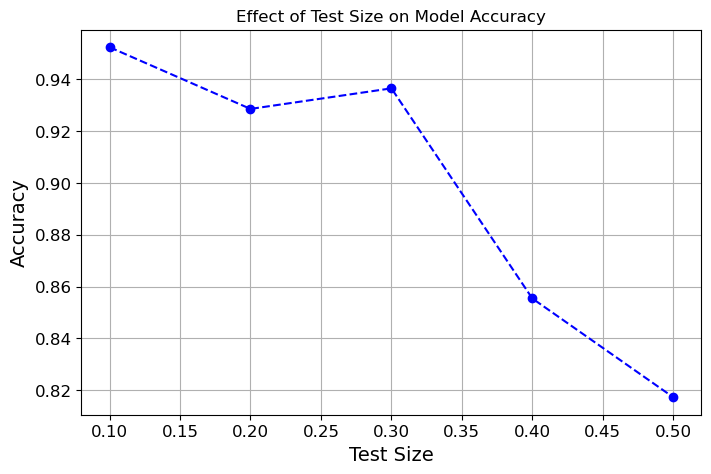

In [82]:
# Define a range of test sizes to experiment with
test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize an empty list to store accuracy scores
accuracy_scores = []

# Experiment with each test size
for test_size in test_sizes:
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Train the decision tree on the current split
    tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
    tree_clf.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = tree_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    print(f"Test Size: {test_size}, Training Size: {1-test_size}, Accuracy: {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(test_sizes, accuracy_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.title('Effect of Test Size on Model Accuracy')
plt.grid(True)
plt.show()

The plot demonstrates the effect of test size on model accuracy, showing that accuracy is highest for smaller test sizes (e.g., 0.1) and decreases as the test size increases (e.g., 0.5). This occurs because smaller test sizes leave more data for training, enabling the model to learn patterns more effectively, resulting in better generalization on the test set. Conversely, larger test sizes reduce the amount of training data, diminishing the model's ability to generalize and leading to lower accuracy. The decline in accuracy is not linear; it remains relatively stable for smaller test sizes (e.g., 0.1 to 0.3) but drops significantly for larger ones (e.g., 0.4 to 0.5). This observation is expected in machine learning, highlighting the trade-off between training and testing data, where smaller test sizes provide better accuracy but require careful evaluation to avoid overfitting.